**TIME SERIES CHARTS**

- Extract VIIRS time series data and convert to pandas dataframe
- Create 2014-2021 time series graph from VIIRS-DNB data for provinces of Bicol
- Create 2014-2021 time series graph for Sum of Lights (SOL) for province of Bicol

In [41]:
import json
import pandas as pd
import geemap, ee
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

try: 
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [42]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01', '2022-10-31')

#using shapefile of the provinces of Bicol to create the point of interest
#
def province(x):
    province = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', x)).first()).geometry()
    return province

albay = province("Albay")
camsur = province("Camarines Sur")
camnorte = province("Camarines Norte")
catanduanes = province("Catanduanes")
masbate = province("Masbate")
sorsogon = province("Sorsogon")
#
albay_poi = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', "Albay")).first()).geometry()
camsur_poi=ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', "Camarines Sur")).first()).geometry()
camnorte_poi = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', "Camarines Norte")).first()).geometry()
catanduanes_poi = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', "Catanduanes")).first()).geometry()
masbate_poi = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', "Masbate")).first()).geometry()
sorsogon_poi = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', "Sorsogon")).first()).geometry()

In [43]:
#extracting all image values in the collection
#getting the mean of the pixels in the region and setting the scale to 500. 
#reducing the info as a property so that the output of the function is to get the mean radiance of a particular region, and
#add this propery to the image along with the date

def albay_poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = albay, scale = 500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

def camsur_poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = camsur, scale = 500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

def camnorte_poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = camnorte, scale = 500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

def catanduanes_poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = catanduanes, scale = 500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

def masbate_poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = masbate, scale = 500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

def sorsogon_poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = sorsogon, scale = 500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

In [44]:
#mapping the function to every image in the collection with the images having the mean value for the region of interest and date
#we'll use this to make time series out of
poi_reduced_imgs_albay = viirs.map(albay_poi_mean)
poi_reduced_imgs_camsur = viirs.map(camsur_poi_mean)
poi_reduced_imgs_camnorte = viirs.map(camnorte_poi_mean)
poi_reduced_imgs_catanduanes = viirs.map(catanduanes_poi_mean)
poi_reduced_imgs_masbate = viirs.map(masbate_poi_mean)
poi_reduced_imgs_sorsogon = viirs.map(sorsogon_poi_mean)

In [45]:
#converting to pandas dataframe, we reduce the image into list of lists. 
# for each image, we have 2-element list that contains the images date and mean value for POI
# each of these lists are themselves elements in the outer list

nested_list_albay = poi_reduced_imgs_albay.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)
nested_list_camsur =  poi_reduced_imgs_camsur.reduceColumns(ee.Reducer.toList(1), ['mean']).values().get(0) #getting mean only
nested_list_camnorte =  poi_reduced_imgs_camnorte.reduceColumns(ee.Reducer.toList(1), ['mean']).values().get(0)
nested_list_catanduanes =  poi_reduced_imgs_catanduanes.reduceColumns(ee.Reducer.toList(1), ['mean']).values().get(0)
nested_list_masbate =  poi_reduced_imgs_masbate.reduceColumns(ee.Reducer.toList(1), ['mean']).values().get(0)
nested_list_sorsogon = poi_reduced_imgs_sorsogon.reduceColumns(ee.Reducer.toList(1), ['mean']).values().get(0)
nl_camsur = np.asarray(nested_list_camsur.getInfo()).squeeze()
nl_camnorte = np.asarray(nested_list_camnorte.getInfo()).squeeze()
nl_catanduanes= np.asarray(nested_list_catanduanes.getInfo()).squeeze()
nl_masbate= np.asarray(nested_list_masbate.getInfo()).squeeze()
nl_sorsogon= np.asarray(nested_list_sorsogon.getInfo()).squeeze()
#turning into data frame the mean of Albay is then

df = pd.DataFrame(nested_list_albay.getInfo(), columns = ['date', 'mean of Albay'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.insert(1, 'Camsur', nl_camsur)
df.insert(2, 'Camnorte',nl_camnorte)
df.insert(3, 'Catanduanes', nl_catanduanes)
df.insert(4, 'Masbate', nl_masbate)
df.insert(5, 'Sorsogon', nl_sorsogon)
df


,mean of Albay,Camsur,Camnorte,Catanduanes,Masbate,Sorsogon
date,,,,,,
2014-01-01,0.110596,0.065999,0.028543,-0.023133,-0.010230,0.001255
2014-02-01,0.176089,0.108292,0.048308,0.002272,0.016753,0.064962
2014-03-01,0.177771,0.115841,0.062508,0.020970,0.043912,0.077489
2014-04-01,0.303269,0.244166,0.207959,0.152258,0.188088,0.217647
2014-05-01,0.240648,0.180025,0.153385,0.082702,0.087459,0.149673
...,...,...,...,...,...,...
2022-06-01,0.731852,0.581292,0.460035,0.404993,0.417798,0.548611
2022-07-01,0.000000,0.001669,0.000000,0.000000,0.051752,0.000000
2022-08-01,0.571139,0.431240,0.359648,0.270991,0.331873,0.397080


Creating a time series graph for VIIRS-DNB from 2014 to 2022

In [53]:
albayMap = geemap.Map()
albayMap.centerObject(albay, zoom =10)
albayMap.add_basemap("SATELLITE")
albayMap.addLayer(albay, {}, "Albay from 2014 to 2022")
albayMap.addLayerControl()
albayMap


Map(center=[13.21475186076421, 123.61592404643157], controls=(WidgetControl(options=['position', 'transparent_…

Text(0.5, 1.0, 'Monthly radiance for Albay (2014 to 2020)')

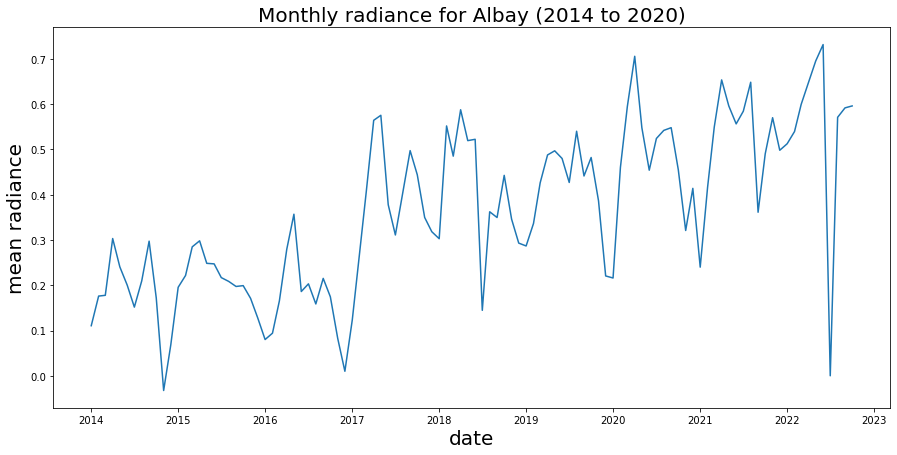

In [54]:
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data= df.iloc[:,0], ax = ax)

ax.set_ylabel('mean radiance', fontsize =20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title('Monthly radiance for Albay (2014 to 2020)', fontsize = 20)

Text(0.5, 1.0, 'Monthly radiance for CamSur (2014 to 2020)')

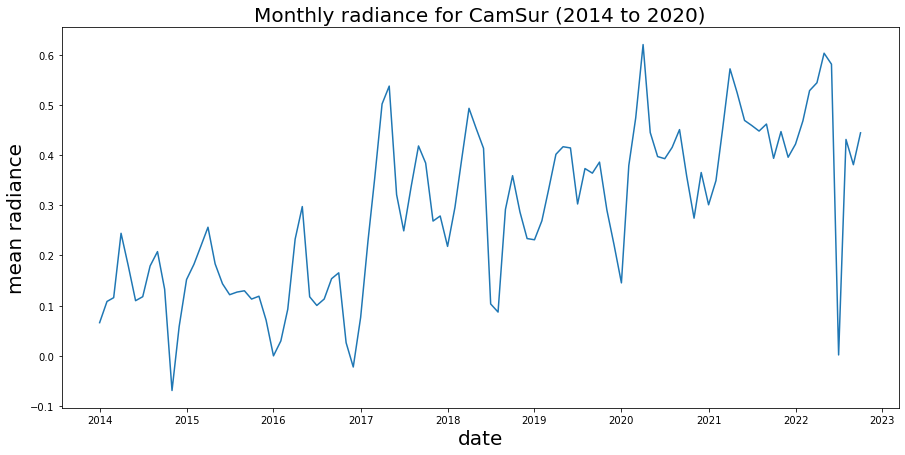

In [56]:
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data= df.iloc[:,1], ax = ax)

ax.set_ylabel('mean radiance', fontsize =20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title('Monthly radiance for CamSur (2014 to 2020)', fontsize = 20)

Text(0.5, 1.0, 'Monthly radiance for CamNorte (2014 to 2020)')

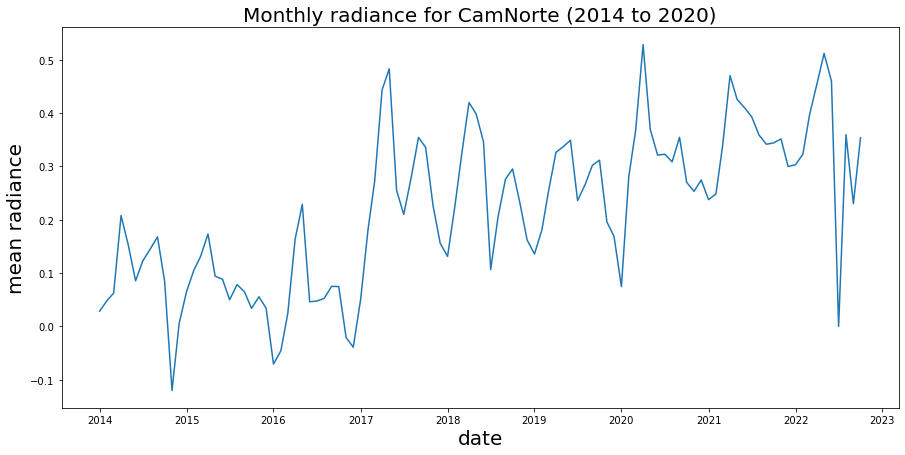

In [57]:
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data= df.iloc[:,2], ax = ax)

ax.set_ylabel('mean radiance', fontsize =20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title('Monthly radiance for CamNorte (2014 to 2020)', fontsize = 20)

Text(0.5, 1.0, 'Monthly radiance for Catanduanes (2014 to 2020)')

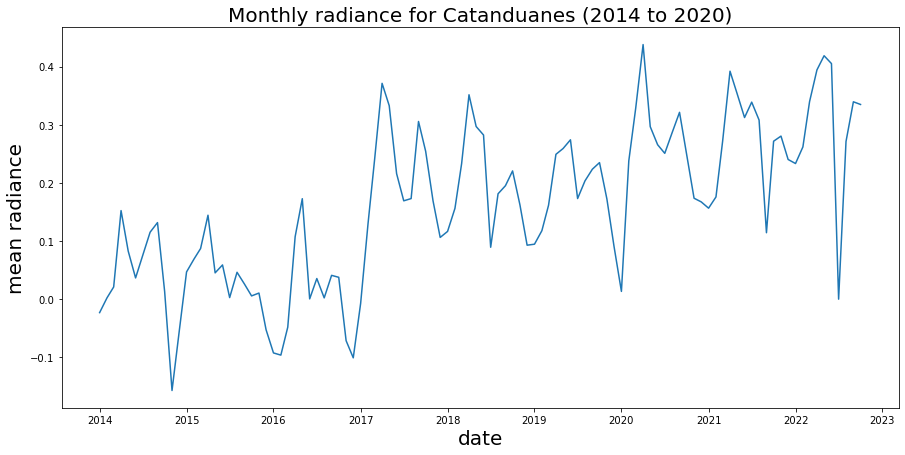

In [58]:
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data= df.iloc[:,3], ax = ax)

ax.set_ylabel('mean radiance', fontsize =20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title('Monthly radiance for Catanduanes (2014 to 2020)', fontsize = 20)

Text(0.5, 1.0, 'Monthly radiance for Masbate (2014 to 2020)')

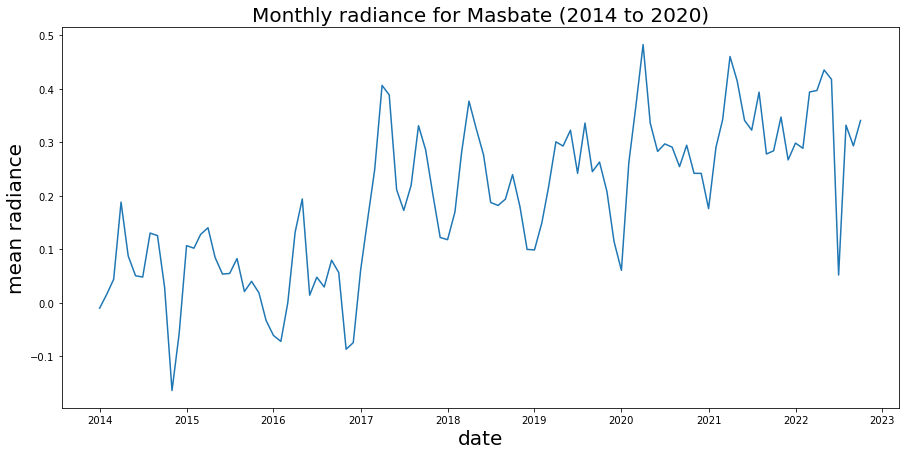

In [59]:
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data= df.iloc[:,4], ax = ax)

ax.set_ylabel('mean radiance', fontsize =20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title('Monthly radiance for Masbate (2014 to 2020)', fontsize = 20)

Text(0.5, 1.0, 'Monthly radiance for Sorsogon (2014 to 2020)')

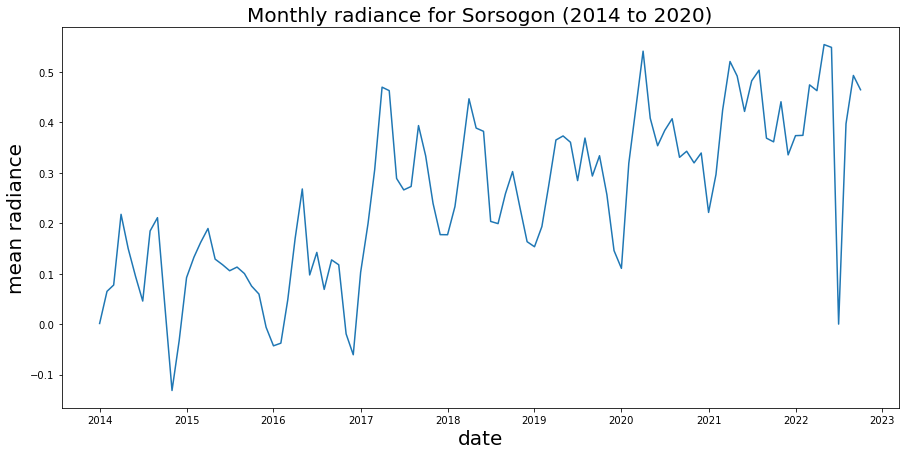

In [60]:
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data= df.iloc[:,5], ax = ax)

ax.set_ylabel('mean radiance', fontsize =20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title('Monthly radiance for Sorsogon (2014 to 2020)', fontsize = 20)

In [63]:
df.idxmax() #spikes

mean of Albay   2022-06-01
Camsur          2020-04-01
Camnorte        2020-04-01
Catanduanes     2020-04-01
Masbate         2020-04-01
Sorsogon        2022-05-01
dtype: datetime64[ns]

Smoothing the time series

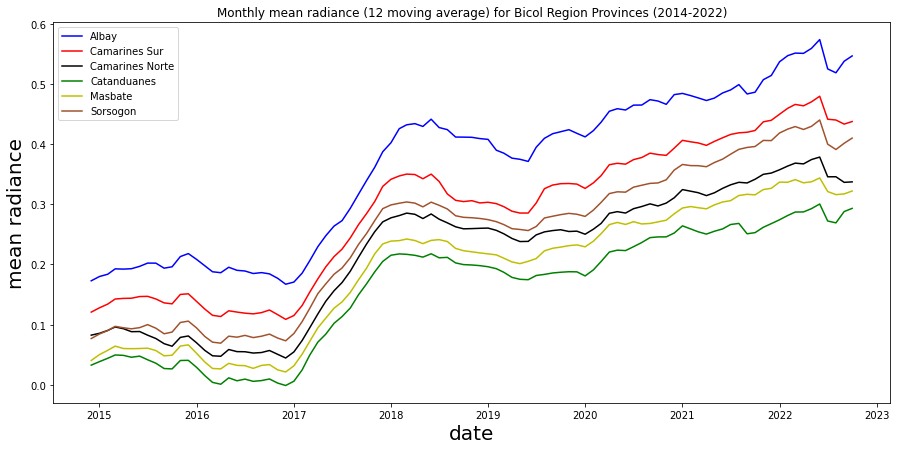

In [77]:
fig,ax = plt.subplots(figsize = (15,7))

#plotting the moving average using .rolling and set a window of 12 monhts
window = 12
sns.lineplot(data = df.iloc[:,0].rolling(window).mean(), label = 'Albay', color = 'b')
sns.lineplot(data = df.iloc[:,1].rolling(window).mean(), label = 'Camarines Sur', color = 'r')
sns.lineplot(data = df.iloc[:,2].rolling(window).mean(), label = 'Camarines Norte', color = 'k')
sns.lineplot(data = df.iloc[:,3].rolling(window).mean(), label = 'Catanduanes', color = 'g')
sns.lineplot(data = df.iloc[:,4].rolling(window).mean(), label = 'Masbate', color = 'y')
sns.lineplot(data = df.iloc[:,5].rolling(window).mean(), label = 'Sorsogon', color = 'sienna')

ax.set_ylabel('mean radiance', fontsize =20)
ax.set_xlabel('date', fontsize= 20)
ax.set_title(f'Monthly mean radiance ({window} moving average) for Bicol Region Provinces (2014-2022)')
plt.show()